## Module 6 Lab.B - Classification Model Using Spark ML Pipeline

"In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known. An example would be assigning a given email into "spam" or "non-spam" classes or assigning a diagnosis to a given patient as described by observed characteristics of the patient (gender, blood pressure, presence or absence of certain symptoms, etc.)."

You will use __CKD__ (Chronic Kidney Disease) dataset and develop a ML Classification model. Then, your model can be used by hospitals to identify which patients might have this disease. 

In the __CKD__ dataset, you have input variables and an output variable named __"Class"__. Basically, this column is the category membership (output column or also known as the response variable). Our goal is to build a mathematical model using the input variables and the category membership (response variable). Then, when a new patient comes in. We won't know if he/she has CKD. But we will know patient's age, al level, bp level, etc. Using these input variables, we will predict if this particilar patient has CKD using the model we ave just built. Amazing right

#### Use cases of Classification
* Detecting fraudulent transaction in bank and insurance industry
* Diagnosing diseases
* Mortgage approval and credit card approval
* Image recognition (recognaizing if an image is a dog or a cat, etc. This is then used in face recognition)
* Identifying which customers will churn 
* Determining if customers will upgrade their product
* And millions of other examples and cases

#### Tasks we do in a data science/analytics project
1. Collect and build the dataset using databases or other resources
2. Get descriptive statistics of the data (mean, variation, etc) and visualize the dataset
3. Check the quality of the data (Missing values, ourliears, errors, etc)
4. Clean the dataset
5. Try to build new features (is there a possibility to add more input variables using the current input variables)
6. Do some data imputation and replace the missing values (or get rid of them)
7. Encode your variables (categorical data must be transformed to dummy variables)
8. Experiment with binning continous data (for example instead of using age as is, you can create 4 levels e.g., below 18, 18 -50, 50-65, and over 65)
9. Build your model. While building it find the best model with some feature elimination and transformation
10. Evaluate the performance of your model using visualization (lift charts, decile tables, etc)
11. Put your model into production so it can be used

### 1. Read the dataset and Encode the class column to 0 and 1

In [0]:
# Your code goes in here
from pyspark.sql import SQLContext # imports the SQl contect class
sqlContext = SQLContext(sc) # creates a sql context so we can read data from tables
spark_df = sqlContext.sql("Select * from ckd") # it queries all the variables from CKD and save it as spark_df
spark_df.count()

Out[71]: 80387

In [0]:
#spark_df.show()
from pyspark.sql.types import IntegerType # imports a class to cast a variable as integer
from pyspark.sql.functions import udf # import user defined functions package
from pyspark.sql.functions import *

ckdlabel = udf(lambda x: 1 if x == 'ckd' else 0, IntegerType()) # creates a UDF that will encode the oputput variable
spark_df = spark_df.withColumn("class", ckdlabel(spark_df["class"])) # creates a new column class label
spark_df.groupBy('class').count().show() # counts the number of 0's and 1's as it uses groupBy

+-----+-----+
class|count|
+-----+-----+
 1|49264|
 0|31123|
+-----+-----+

### 2. Do some visualizations to summarize your dataset

In [0]:
display(spark_df.describe()) # displays the summary statistics

summary,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,78297,78743,71154,71337,70950,50902,67632,79534,79534,72684,77096,77702,66062,65855,71111,67822,61633,58543,79953,79747,79953,80200,80200,80200,80387
mean,51.55873149673678,76.3299975870871,1.01990372993768,0.9922620799865427,0.4661874559548978,null,null,null,null,147.60383303065325,57.39561066722032,3.106161360067809,137.52210801973902,4.65087540809309,12.542765535570794,38.89337088260492,8436.298736066718,4.6989580308490035,null,null,null,null,null,null,0.6128354087103636
stddev,16.86797970453218,13.645864628382535,0.006927895441447461,1.3424916988078799,1.1105847148292969,null,null,null,null,79.0401198912799,51.33189336219994,5.812264315900867,10.260873053978967,3.372305341230911,2.9178041179799994,9.02154491493883,2929.7974644268725,0.9814078816080343,null,null,null,null,null,null,0.48710483692093925
min,2,50,1.01,0,0,abnormal,abnormal,notpresent,notpresent,22,1.5,0.4,4.5,2.5,3.1,9.0,2200,2.1,no,no,no,good,good,no,0
max,90,180,1.03,5,5,normal,normal,present,present,490,391.0,76.0,163.0,47.0,17.8,54.0,26400,6.5,yes,yes,yes,poor,yes,yes,1


In [0]:
#Hypothesis: People with high blood glucose tested without fasting has higher chance of CKD
hypodf=spark_df.groupby('class').mean('bgr') # computes the average bgr by class
hypodf.show()

+-----+------------------+
class| avg(bgr)|
+-----+------------------+
 1|175.69867115852517|
 0| 107.4940881763527|
+-----+------------------+

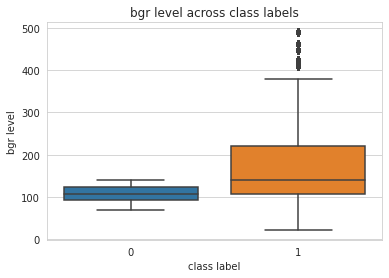

In [0]:
## using seaborn or matplotlib in Jupyter Notebook
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

fig, ax = plt.subplots() # creates figure and axes space
sns.set_style("whitegrid") # sets the backgropund to white with grids

pandas_df = spark_df.select('bgr', 'class').toPandas() # selects class and bgr variables and converts the dataset from spark df to pandas df

ax = sns.boxplot(x='class', y='bgr', data = pandas_df) # creates a boxplot

ax.set_title('bgr level across class labels') # sets the title of the boxplot
ax.set(xlabel='class label', ylabel='bgr level') # names the axes

display(fig)

In [0]:
#Old people are more prone to CKD
age_df=spark_df.groupby('class').mean('age') # computes the average age by class (as seen people with ckd are significantly older)
age_df.show()

+-----+------------------+
class| avg(age)|
+-----+------------------+
 1|54.864234007977544|
 0| 46.49226887494339|
+-----+------------------+

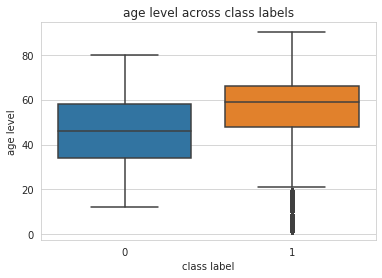

In [0]:
## using seaborn or matplotlib in Jupyter Notebook
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

fig, ax = plt.subplots() # creates figure and axes space
sns.set_style("whitegrid") # sets the backgropund to white with grids

pandas_df = spark_df.select('age', 'class').toPandas() # selects age and class variables and save it as a pandas df

ax = sns.boxplot(x='class', y='age', data = pandas_df) #  create sa box plot

ax.set_title('age level across class labels') # sets the title of the boxplot
ax.set(xlabel='class label', ylabel='age level') # names the axes

display(fig)

#Old people tend to be more prone to CKD - This might not be so true

### 3. Replacing Missing Values - Numerical Variables
Write a transfomation class and its functions for replacing numerical missing values with the median. (You will write a trasformer class). Create the transformers for numerical variables using the transformation class you have just written

In [0]:
#Setting the target variable
target = 'class'

In [0]:
# categorical variables
dtypes = spark_df.dtypes
cat_input = [] # creates a variable of list type to save the categorical input variables
for i in range(0, len(spark_df.columns)): # iterate over the spark_df variables
  if dtypes[i][1] == 'string': #identify categorical variable
    cat_input.append(dtypes[i][0]) # add te name of the categorical variable to cat_input
cat_input = list(set(cat_input)-set(target)) 
cat_input

Out[79]: ['rbc', 'dm', 'pc', 'appet', 'htn', 'ane', 'ba', 'cad', 'pcc', 'pe']

In [0]:
# numerical variables
num_input = list(set(spark_df.columns) - set([target]) - set(cat_input)) # identifies the numerical input variables 
num_input

Out[80]: ['sc',
 'rbcc',
 'bp',
 'age',
 'sod',
 'bgr',
 'sg',
 'al',
 'wbcc',
 'pot',
 'pcv',
 'hemo',
 'bu',
 'su']

### 4. Create Custom Transformer for Data Imputation

In [0]:
from pyspark.sql.types import DoubleType
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col



class NumericImputer(Transformer, HasInputCol, HasOutputCol): # replacing missing values in numerical columns

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(NumericImputer, self).__init__()  # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol)  # do not change this part at all when creating custom transformers

        
    def setParams(self, inputCol=None, outputCol=None):  # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol)  # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):  # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      
      
      from pyspark.sql.functions import when  
      from pyspark.sql.types import DoubleType
      median_v = dataset.approxQuantile(in_col, [0.5], 0)[0] # compute median #dataset = dataset.fillna(median_v, subset=in_col)
      return dataset.withColumn(out_col, when(col(in_col).isNull(), median_v).otherwise(col(in_col)).cast(DoubleType())) # replacing null values with median if the value is null otherwise keeping it as is

In [0]:
numericimputers = [] # creating an empty list
for column in num_input: # creating a list of numeric imputers each of which responsible for imputing a variable
  numericimputers.append(NumericImputer(inputCol = column , outputCol = column))
numericimputers

Out[82]: [NumericImputer_d149a34a870a,
 NumericImputer_cd6942a1aa55,
 NumericImputer_940a38da6408,
 NumericImputer_cbf59bb4bef9,
 NumericImputer_91e69d9e9044,
 NumericImputer_04fe51d86f30,
 NumericImputer_bd5140b2be18,
 NumericImputer_8a38ad13a42a,
 NumericImputer_357072d037d4,
 NumericImputer_819058448f61,
 NumericImputer_286bf78071d0,
 NumericImputer_d2d60427bb4c,
 NumericImputer_b526ed6623be,
 NumericImputer_9b0de5ac56d2]

### 5. Replacing Missing Values - Categorical Variables
Write a transfomation class and its functions for replacing categorical missing values with the mode. (You will write a trasformer class). Create the transformers for categorical variables using the transformation class you have just written

In [0]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col

class CategoricalImputer(Transformer, HasInputCol, HasOutputCol): # replacing missing values in categorical columns

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(CategoricalImputer, self).__init__()  # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol)  # do not change this part at all when creating custom transformers

        
    def setParams(self, inputCol=None, outputCol=None):  # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol)  # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):  # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      
      #Groupby column name in_col
      temp = dataset.groupby(in_col).count() # groupby and count the levels (such as how many observations there are for each level)
      temp = temp.filter(temp[in_col]!= 'null') # exclude the null in case the domintaing level is null
      #sort it and convert to pandas
      sorted_df = temp.sort(temp['count'].desc()).toPandas() # sort it find the most occuring level (which is the mode)
      #mode 
      mode_v = sorted_df.loc[0][in_col] # get the mode
      
      return dataset.withColumn(out_col, when(col(in_col).isNull(), mode_v).otherwise(col(in_col))) # repace the nulls with the mode for that variable

In [0]:
cat_imputers = [CategoricalImputer(inputCol = column, outputCol = column) for column in cat_input]
cat_imputers

Out[84]: [CategoricalImputer_f91a7a74f94d,
 CategoricalImputer_cf4bc78320ba,
 CategoricalImputer_410a2d0c4eab,
 CategoricalImputer_7e43bf08328f,
 CategoricalImputer_3bae4a968a87,
 CategoricalImputer_54c7605677d4,
 CategoricalImputer_48f5c1dbeec9,
 CategoricalImputer_f52dc003cf4d,
 CategoricalImputer_51aefcdbb64b,
 CategoricalImputer_fd91c15de459]

### 6. Normalize Variables
Write a transfomation class and its functions for normalizing numerical data. The _transform function should normalize your column using the feature scaling method: (x-xmin)/(xmax-xmin)

Create the transformers for numerical variables using the transformation class you have just written

In [0]:
# normalize a dataset

from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


class Scaler(Transformer, HasInputCol, HasOutputCol): # we will scale the variables (x-xmin/range)

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(Scaler, self).__init__() # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol) # do not change this part at all when creating custom transformers

        
        
    def setParams(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol) # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):
      from pyspark.sql.functions import stddev, mean, col
      out_col = self.getOutputCol() # get the out_col
      in_col = dataset[self.getInputCol()] # get the input_col
      xmin, xmax = dataset.select(min(in_col), max(in_col)).first() # find max and min
      return dataset.withColumn(out_col, (in_col - xmin)/(xmax-xmin)) # scale the variable and save it in place


In [0]:
scalers = [Scaler(inputCol = column, outputCol = column+"_scaled") for column in num_input]
scalers

Out[86]: [Scaler_c2d978a64847,
 Scaler_191d393c0600,
 Scaler_25decb5712b2,
 Scaler_5da076bbce25,
 Scaler_1c60754817b2,
 Scaler_64b40406b592,
 Scaler_8ae9e79f20ec,
 Scaler_ad04822af720,
 Scaler_b9a5522a4924,
 Scaler_866db464f761,
 Scaler_ebde357a1dd6,
 Scaler_f2e856bc1090,
 Scaler_4fc5b12fa215,
 Scaler_1f4ceb9348f0]

### 7. Encode Dummy Variables
Create the transformers for encoding dummy variables

In [0]:
from pyspark import keyword_only  
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in cat_input] # this will first create indexers (it means it will number each category in a variable)
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in cat_input] # This will use the numbers to create the binary variables

### 8. Combine Steps
We will create a ML pipelibe

In [0]:
input_cols = [] # creates an empty list
for i in cat_input: #iterates over categorical variables
  input_cols.append(i+"_dummy") # saves the name of the dummy encoded categorical variables (they are not categorical now though)
for i in num_input: # iterates over the numerical variables
  input_cols.append(i+"_scaled") # saves the name of standardized numerical variables
input_cols

Out[88]: ['rbc_dummy',
 'dm_dummy',
 'pc_dummy',
 'appet_dummy',
 'htn_dummy',
 'ane_dummy',
 'ba_dummy',
 'cad_dummy',
 'pcc_dummy',
 'pe_dummy',
 'sc_scaled',
 'rbcc_scaled',
 'bp_scaled',
 'age_scaled',
 'sod_scaled',
 'bgr_scaled',
 'sg_scaled',
 'al_scaled',
 'wbcc_scaled',
 'pot_scaled',
 'pcv_scaled',
 'hemo_scaled',
 'bu_scaled',
 'su_scaled']

In [0]:
# your code goes in here
from pyspark.ml.feature import StringIndexer
import functools 
import operator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

stages = []
assembler = VectorAssembler(inputCols= input_cols, outputCol="features") #conactenates all input variables and names as features [[0,1,0],30,20,40000]
stages = functools.reduce(operator.concat, [numericimputers, cat_imputers, indexers, encoders, scalers]) #indexers,  encoders, standardizers])
stages.append(assembler)
stages



Out[89]: [NumericImputer_d149a34a870a,
 NumericImputer_cd6942a1aa55,
 NumericImputer_940a38da6408,
 NumericImputer_cbf59bb4bef9,
 NumericImputer_91e69d9e9044,
 NumericImputer_04fe51d86f30,
 NumericImputer_bd5140b2be18,
 NumericImputer_8a38ad13a42a,
 NumericImputer_357072d037d4,
 NumericImputer_819058448f61,
 NumericImputer_286bf78071d0,
 NumericImputer_d2d60427bb4c,
 NumericImputer_b526ed6623be,
 NumericImputer_9b0de5ac56d2,
 CategoricalImputer_f91a7a74f94d,
 CategoricalImputer_cf4bc78320ba,
 CategoricalImputer_410a2d0c4eab,
 CategoricalImputer_7e43bf08328f,
 CategoricalImputer_3bae4a968a87,
 CategoricalImputer_54c7605677d4,
 CategoricalImputer_48f5c1dbeec9,
 CategoricalImputer_f52dc003cf4d,
 CategoricalImputer_51aefcdbb64b,
 CategoricalImputer_fd91c15de459,
 StringIndexer_7d01652d9d2a,
 StringIndexer_6fdaf171858f,
 StringIndexer_a460937671ed,
 StringIndexer_fb0b27557c8c,
 StringIndexer_9e43b4166dce,
 StringIndexer_bcb5b83654c6,
 StringIndexer_430c7b848147,
 StringIndexer_088228e63513,
 StringIndexer_5553f0c7eee0,
 StringIndexer_4cdda6e12011,
 OneHotEncoder_68ab3520770c,
 OneHotEncoder_b5c24eb4ace2,
 OneHotEncoder_141a72a59801,
 OneHotEncoder_9d3bf0e9b766,
 OneHotEncoder_bfb16ffb04a4,
 OneHotEncoder_cd125d9d90ee,
 OneHotEncoder_a84648699753,
 OneHotEncoder_16f5ec35a0ca,
 OneHotEncoder_e347b13d5185,
 OneHotEncoder_fb206938971c,
 Scaler_c2d978a64847,
 Scaler_191d393c0600,
 Scaler_25decb5712b2,
 Scaler_5da076bbce25,
 Scaler_1c60754817b2,
 Scaler_64b40406b592,
 Scaler_8ae9e79f20ec,
 Scaler_ad04822af720,
 Scaler_b9a5522a4924,
 Scaler_866db464f761,
 Scaler_ebde357a1dd6,
 Scaler_f2e856bc1090,
 Scaler_4fc5b12fa215,
 Scaler_1f4ceb9348f0,
 VectorAssembler_52e7cb3455e9]

### 9. Run Pipeline

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages) # creates the pipeline object
spark_df = pipeline.fit(spark_df).transform(spark_df) # runs the pipeline

### 10. Create Training & Testing

In [0]:
train, test = spark_df.randomSplit([0.7, 0.3], seed = 2018) # divides the dataset into training and testing
print("Training Dataset Count: " + str(train.count())) # gives hpow many observations in the training set
print("Test Dataset Count: " + str(test.count())) # gives how many observations in the test set

Training Dataset Count: 56274
Test Dataset Count: 24113

### 11. Create Logistic Regression

In [0]:
lr = LogisticRegression(labelCol=target, featuresCol="features", maxIter=10) # creates a logistic regression instance (model)
logRegModel = lr.fit(train) # trains the model

In [0]:
logRegModel.transform(train).select('probability', 'prediction').toPandas() # gets the model probabilities and classes

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[93]:

,probability,prediction
0,"[0.00011897737763710987, 0.9998810226223629]",1.0
1,"[0.00011897737763710987, 0.9998810226223629]",1.0
2,"[0.00011897737763710987, 0.9998810226223629]",1.0
3,"[0.00011897737763710987, 0.9998810226223629]",1.0
4,"[0.00011897737763710987, 0.9998810226223629]",1.0
...,...,...
56269,"[2.311279824709008e-06, 0.9999976887201752]",1.0
56270,"[2.311279824709008e-06, 0.9999976887201752]",1.0
56271,"[3.6040476210916066e-06, 0.9999963959523789]",1.0
56272,"[1.9522212295236404e-05, 0.9999804777877047]",1.0


### 12. Model Parameters

In [0]:
print("Coefficients: \n" + str(logRegModel.coefficientMatrix)) # gives the model coef
print("Intercept: " + str(logRegModel.interceptVector)) # gives the model intercept

Coefficients: 
DenseMatrix([[-1.26871866, -2.07381051, -0.91314224, -0.7684285 , 2.19166811,
 -1.98161245, -0.64657988, 1.50857867, 0.62827133, -0.08037927,
 -0.56169471, 2.11543362, 12.94147771, -3.91554855, 7.33288623,
 -0.4721993 , 16.57645053, 6.09916647, -4.65475317, 5.67350563,
 4.2499181 , 1.46020263, -5.82999487, -7.19235841, 5.05260359,
 3.59180687]])
Intercept: [0.622682080432849]

### 13.  Performance checks
1. Write code to calculate accuracy rate, false positive rate, false negative rate
2. Write code to visualize and display ROC (this is called ROC)

#### 13.1  Performance checks for Training

In [0]:
summary = logRegModel.summary # gets the modelo summary and saves it as summary
accuracy = summary.accuracy # access the accuracy within model summary
falsePositiveRate = summary.weightedFalsePositiveRate # access the FPR within model summary
truePositiveRate = summary.weightedTruePositiveRate # access the TPR within model summary
fMeasure = summary.weightedFMeasure() # access the FM within model summary
precision = summary.weightedPrecision # access the precision within model summary
recall = summary.weightedRecall # access the recall within model summary
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.9888936276077762
FPR: 0.009790268615961604
TPR: 0.9888936276077762
F-measure: 0.988907102907771
Precision: 0.9889782378820391
Recall: 0.9888936276077762

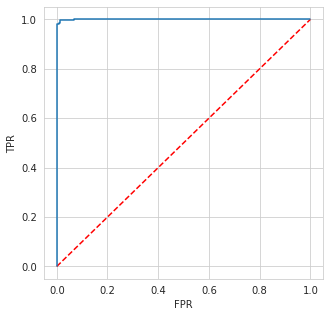

In [0]:
import matplotlib.pyplot as plt # imparts matplotlib for viz
plt.figure(figsize=(5,5)) # determines the figure size 
plt.plot([0, 1], [0, 1], 'r--') # (draws the diagonal red line - random decision line)
plt.plot(summary.roc.select('FPR').collect(), # plots the FPR vs TPR
         summary.roc.select('TPR').collect())
plt.xlabel('FPR') # names the x axis
plt.ylabel('TPR')  # names the y axis
display(plt.show()) # displays the plot

#### 12.2  Performance checks for Testing

In [0]:
predictions = logRegModel.transform(test) # takes the test data and makes predictions
predictions = predictions.withColumnRenamed("class", "label") # rename the class column as label (actual values)
predictions.select('label', 'prediction', 'probability').show(10) # selects the actual, predicted, and probability


+-----+----------+--------------------+
label|prediction| probability|
+-----+----------+--------------------+
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
 1| 1.0|[1.18977377637109...|
+-----+----------+--------------------+
only showing top 10 rows

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator # imports the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions)) # evaluates the results using the predictions dataframe above

Test Area Under ROC 0.9995987794565672